# Regression with a mixture density network

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tensorflow as tf
from util import plot_1d_graphs,gpu_sess
%matplotlib inline
print ("Packages loaded.")

Packages loaded.


### Define Class

In [2]:
tfd = tf.contrib.distributions
tfrni = tf.random_normal_initializer
tfci = tf.constant_initializer
tfrui = tf.random_uniform_initializer
class MDN_class(object):
    def __init__(self,_name='mdn',_x_dim=2,_y_dim=1,_k=5,_hids=[32,32],_actv=tf.nn.tanh,
                 _sig_max=0,_SCHEDULE_SIG_MAX=False,
                 _sess=None,_VERBOSE=True):
        # Parse arguments
        self.name = _name
        self.x_dim = _x_dim
        self.y_dim = _y_dim
        self.k = _k
        self.hids = _hids
        self.actv = _actv
        self.sig_max = _sig_max
        self.SCHEDULE_SIG_MAX = _SCHEDULE_SIG_MAX
        self.sess = _sess
        self.VERBOSE = _VERBOSE
        # Build graph
        self._build_graph()
        # Check parameters
        self.check_params()
        # Initialize parameters 
        self.sess.run(tf.global_variables_initializer())
        
    # Build graph 
    def _build_graph(self):
        # Build
        with tf.variable_scope(self.name,reuse=False) as scope:
            # Placeholders
            self.x = tf.placeholder(shape=[None,self.x_dim],dtype=tf.float32,name='x') # [n x x_dim]
            self.y = tf.placeholder(shape=[None,self.y_dim],dtype=tf.float32,name='y') # [n x y_dim]
            # Layers
            self.layers = []
            self.net = self.x
            self.layers.append(self.net)
            for h_idx,hid in enumerate(self.hids):
                self.net = tf.layers.dense(self.net,hid,activation=self.actv,
                                           kernel_initializer=tfrni(stddev=0.01),bias_initializer=tfci(0),
                                           name='hid_%d'%(h_idx))
                self.layers.append(self.net)
            self.pi = tf.layers.dense(self.net,self.k,activation=None,
                                      kernel_initializer=tfrni(stddev=0.01),bias_initializer=tfci(0),
                                      name='pi') # [n x k]
            self.pi = tf.nn.softmax(5*self.pi,axis=1)
            self.layers.append(self.pi)
            self.mu = tf.layers.dense(self.net,self.y_dim*self.k,activation=None,
                                      kernel_initializer=tfrni(stddev=0.01),
                                      bias_initializer=tfrui(minval=-3,maxval=+3),
                                      name='mu')
            self.mu = tf.reshape(self.mu,shape=(-1,self.y_dim,self.k)) # [n x y_dim x k]
            self.layers.append(self.mu)
            self.logvar = tf.layers.dense(self.net,self.y_dim*self.k,activation=None,
                                          kernel_initializer=tfrni(stddev=0.01),bias_initializer=tfci(0),
                                          name='logvar') 
            self.logvar = tf.reshape(self.logvar,shape=(-1,self.y_dim,self.k)) # [n x y_dim x k]
            self.sig_rate = tf.placeholder(shape=[],dtype=tf.float32,name='sig_rate') # [1]
            if self.sig_max == 0:
                self.var = tf.exp(self.logvar)
            else:
                self.var = self.sig_max*self.sig_rate*tf.nn.sigmoid(self.logvar)
            self.layers.append(self.logvar)
        # Computations 
        self.cat = tfd.Categorical(probs=self.pi)            
        self.comps = [tfd.MultivariateNormalDiag(loc=loc,scale_diag=scale) 
                        for loc,scale in zip(tf.unstack(tf.transpose(self.mu,[2,0,1])),
                                             tf.unstack(tf.transpose(self.var,[2,0,1])))]
        self.tfd_mog = tfd.Mixture(cat=self.cat,components=self.comps)
        self.log_liks = self.tfd_mog.log_prob(self.y) # [n]
        self.log_lik = tf.reduce_mean(self.log_liks) # [1]
        # Sampler
        self.y_sample = tf.squeeze(self.tfd_mog.sample(1),[0]) # [n x y_dim]
        # Optimizer
        _g_vars = tf.trainable_variables()
        self.c_vars = [var for var in _g_vars if '%s/'%(self.name) in var.name]
        self.l2_reg = 1e-6*tf.reduce_sum(tf.stack([tf.nn.l2_loss(v) for v in self.c_vars])) # [1]
        self.cost = -self.log_lik + self.l2_reg # [1]
        self.optm = tf.train.RMSPropOptimizer(learning_rate=1e-3).minimize(self.cost)

    # Check parameters
    def check_params(self):
        _g_vars = tf.global_variables()
        self.g_vars = [var for var in _g_vars if '%s/'%(self.name) in var.name]
        if self.VERBOSE:
            print ("==== Global Variables ====")
        for i in range(len(self.g_vars)):
            w_name  = self.g_vars[i].name
            w_shape = self.g_vars[i].get_shape().as_list()
            if self.VERBOSE:
                print ("  [%02d/%d] Name:[%s] Shape:[%s]" % (i,len(self.g_vars),w_name,w_shape))
        # Print layers
        if self.VERBOSE:
            print ("==== Layers ====")
            n_layers = len(self.layers)
            for i in range(n_layers):
                print ("  [%0d/%d] %s %s"%(i,n_layers,self.layers[i].name,self.layers[i].shape))
                
    # Plot results
    def plot_result(self,_x_test,_title='MDN result',_figsize=(15,5),_wspace=0.05,_hspace=0.05,_sig_rate=1.0,_pi_th=0.0,
                   _x_train=None,_y_train=None):
        # sample
        y_sample = self.sess.run(self.y_sample,feed_dict={self.x:_x_test,self.sig_rate:_sig_rate}) # [n x y_dim] 
        mu,var,pi = self.sess.run([self.mu,self.var,self.pi],feed_dict={self.x:_x_test,self.sig_rate:_sig_rate})
        # plot per each output dimensions (self.y_dim)
        nr,nc = 1,self.y_dim
        gs  = gridspec.GridSpec(nr,nc)
        gs.update(wspace=_wspace, hspace=_hspace)
        fig = plt.figure(figsize=_figsize)
        fig.suptitle(_title, size=15)
        for i in range(nr*nc): # per each dimension
            ax = plt.subplot(gs[i])
            cmap = plt.get_cmap('gist_rainbow')
            colors = [cmap(ii) for ii in np.linspace(0,1,self.k)]
            if _x_train is not None:
                plt.plot(_x_train[:,0],_y_train[:,i],'k.')
            plt.plot(_x_test[:,0],y_sample[:,i],'rx') # plot samples per each dimension
            for j in range(self.k): # per each mixture, plot variance
                idx = np.where(pi[:,j]>_pi_th)[0]
                plt.fill_between(_x_test[idx,0],mu[idx,i,j]-2*var[idx,i,j],mu[idx,i,j]+2*var[idx,i,j],
                             facecolor=colors[j], interpolate=True, alpha=0.3)            
            for j in range(self.k): # per each mixture, plot mu
                idx = np.where(pi[:,j]>_pi_th)[0]
                plt.plot(_x_test[:,0],mu[:,i,j],'-',color=[0.8,0.8,0.8],linewidth=1)
                plt.plot(_x_test[idx,0],mu[idx,i,j],'-',color=colors[j],linewidth=3)
        plt.show()
        
    # Train 
    def train(self,_x_train,_y_train,_x_test,_max_iter=10000,_pi_th=0.1,_SHOW_EVERY=10):
        n_train = _x_train.shape[0]
        for iter in range(_max_iter): 
            iter_rate_1to0 = np.exp(-5*((iter+1.0)/_max_iter)**2)
            iter_rate_0to1 = 1-iter_rate_1to0
            if self.SCHEDULE_SIG_MAX: # schedule sig_max
                sig_rate = iter_rate_0to1
            r_idx = np.random.permutation(n_train)[:128]
            x_batch,y_batch = _x_train[r_idx,:],_y_train[r_idx,:] # current batch
            _,cost_val = self.sess.run([self.optm,self.cost],
                                       feed_dict={self.x:x_batch,self.y:y_batch,
                                                  self.sig_rate:sig_rate})
            # See progress 
            if ((iter%(_max_iter//_SHOW_EVERY))==0) | (iter==(_max_iter-1)):
                y_sample = self.sess.run(self.y_sample,
                                         feed_dict={self.x:x_test,self.sig_rate:sig_rate}) # sample 
                # Plot results
                self.plot_result(_x_test=_x_test,_x_train=_x_train,_y_train=_y_train,
                                 _sig_rate=sig_rate,_pi_th=_pi_th,
                                 _title='[%d/%d] Black dots:training data / Red crosses:samples'%(iter,_max_iter))
                # Print-out
                print ("[%03d/%d] cost:%.4f"%(iter,_max_iter,cost_val)) 
        
print ("Class ready.")

Class ready.


### Train

MDN instantiated.


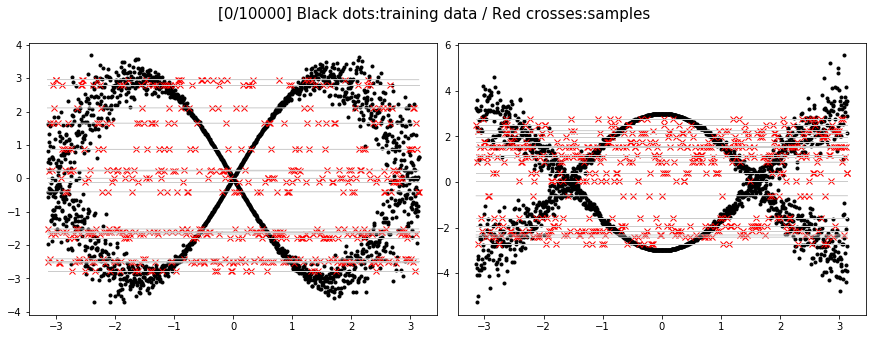

[000/10000] cost:555604754038784.0000


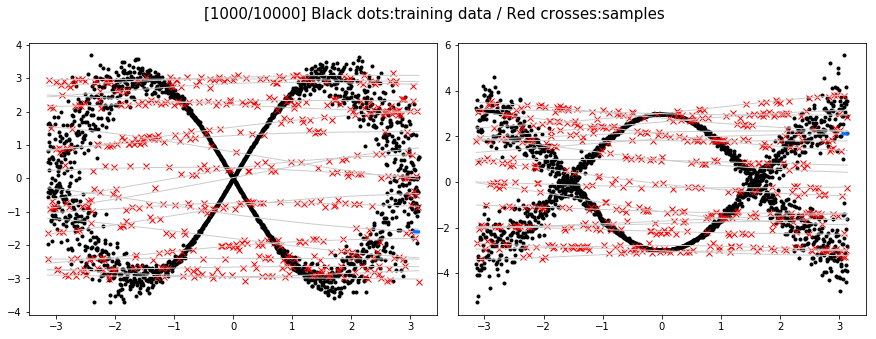

[1000/10000] cost:49.4018


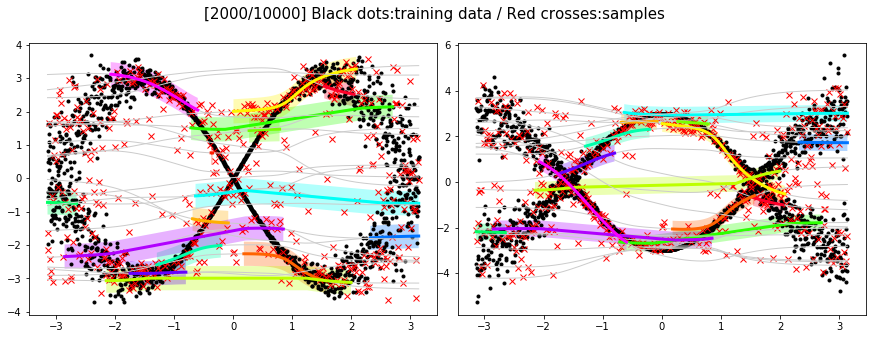

[2000/10000] cost:2.5968


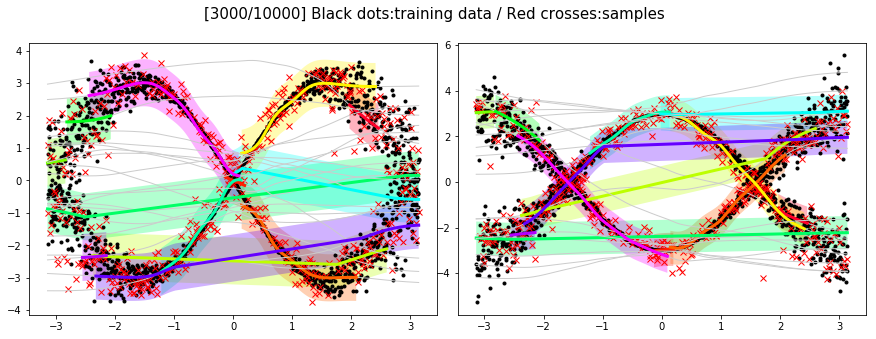

[3000/10000] cost:1.5547


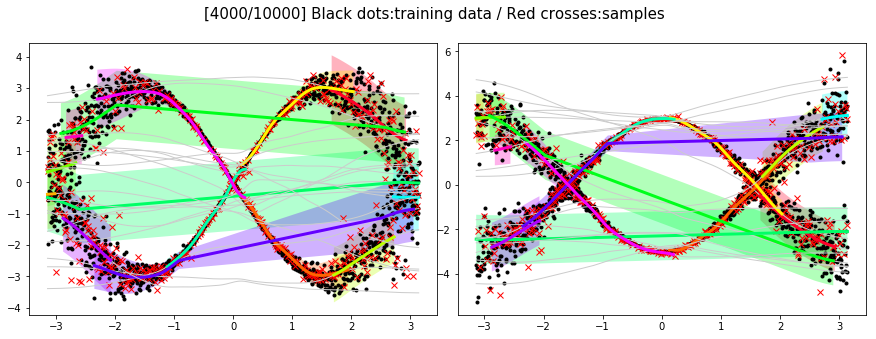

[4000/10000] cost:0.4226


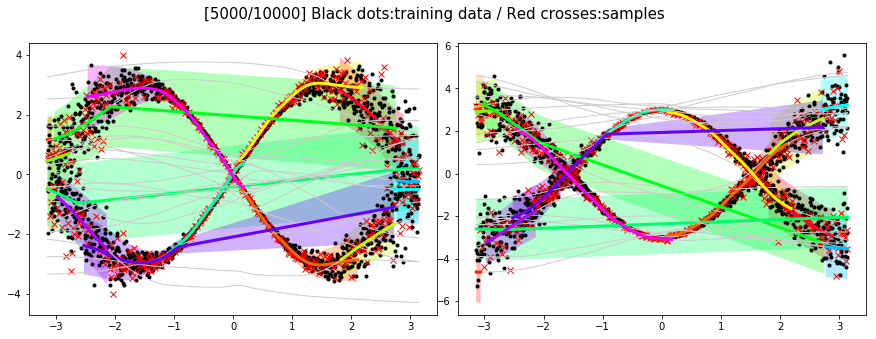

[5000/10000] cost:0.6968


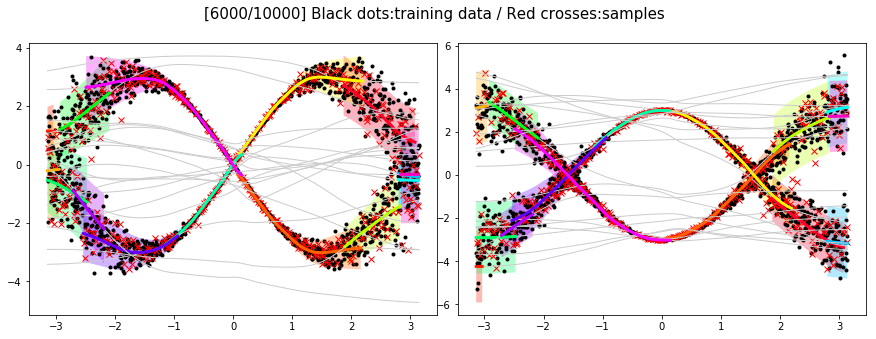

[6000/10000] cost:0.1032


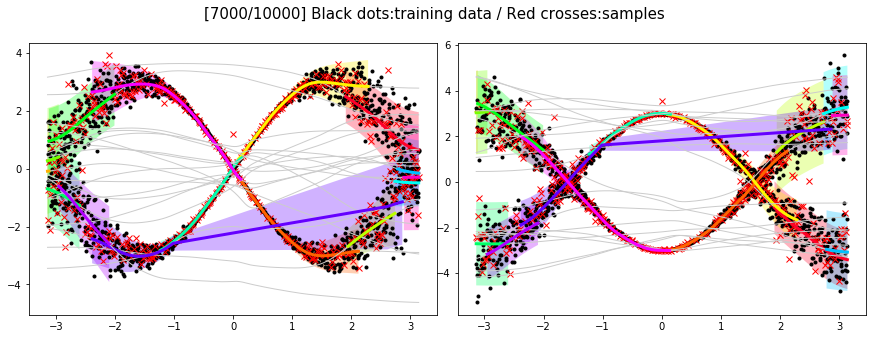

[7000/10000] cost:0.5719


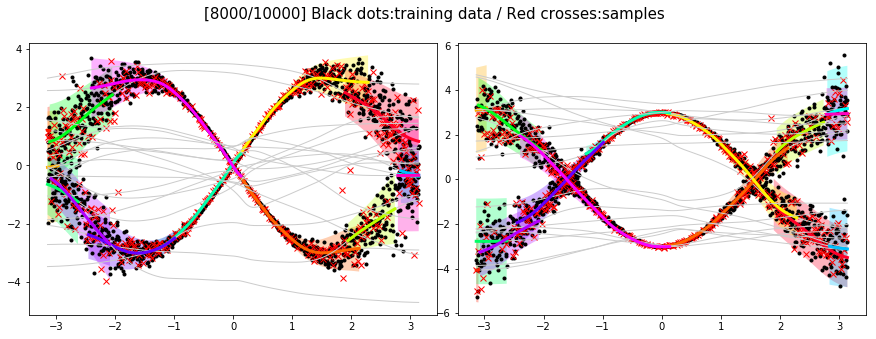

[8000/10000] cost:0.0883


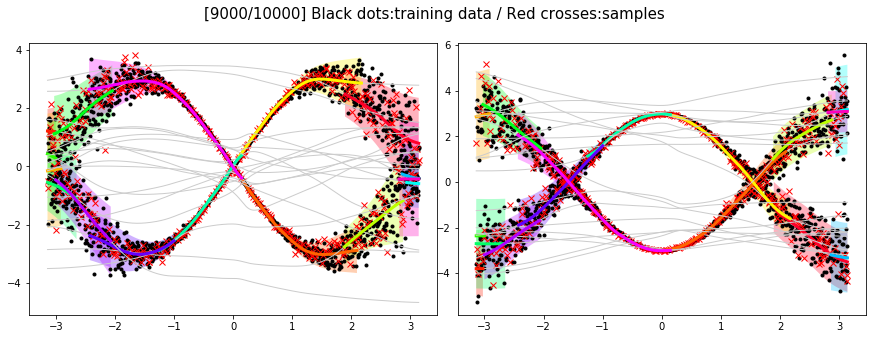

[9000/10000] cost:0.2538


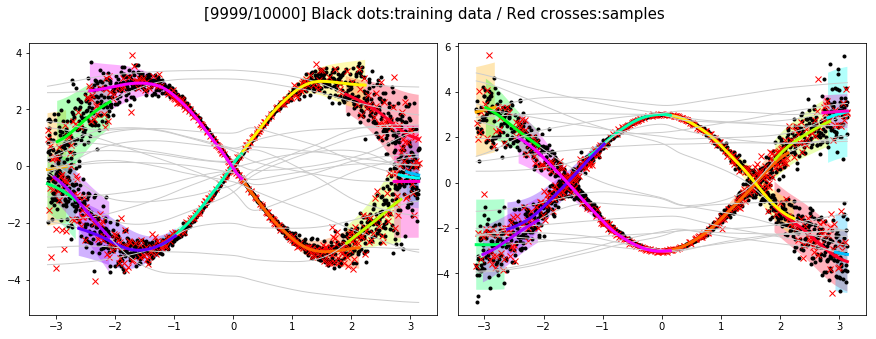

[9999/10000] cost:0.1382


In [3]:
tf.reset_default_graph() # Reset graph
tf.set_random_seed(seed=1)
np.random.seed(seed=1)
sess = gpu_sess()
M = MDN_class(_name='mdn',_x_dim=1,_y_dim=2,_k=20,_hids=[64,64],_actv=tf.nn.tanh,
              _sig_max=1.0,_SCHEDULE_SIG_MAX=True,
              _sess=sess,_VERBOSE=False)
print ("MDN instantiated.")
# Training data
x_min,x_max,n_train_half = -3.14,+3.14,1000
x_train = np.linspace(x_min,x_max,n_train_half).reshape((-1,1)) # [1000 x 1]
y_train = np.concatenate((3*np.sin(x_train),3*np.cos(x_train)),axis=1) # [1000 x 2]
x_train,y_train = np.concatenate((x_train,x_train),axis=0),np.concatenate((y_train,-y_train),axis=0)
n_train = y_train.shape[0]
y_train = y_train + np.random.randn(n_train,2)*np.square(x_train/x_max)

# Train 
max_iter = 10000
x_test = np.linspace(x_min,x_max,500).reshape((-1,1))
M.train(_x_train=x_train,_y_train=y_train,_x_test=x_test,_max_iter=max_iter,_pi_th=0.1,_SHOW_EVERY=10)